Cell 1 – Setup imports + project root

In [1]:
# 02_embeddings_clustering.ipynb

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.config import load_config
from src.data.loader import load_jobs
from src.embeddings.embedder import embed_texts, build_and_save_embeddings
from src.evaluation.metrics import internal_cluster_metrics

sns.set(style="whitegrid")

cfg = load_config()
TEXT_COL = cfg["jobs"]["text_column"]

EMB_PATH = PROJECT_ROOT / "results" / "embeddings" / "jobs_embeddings.npy"
LABELS_PATH = PROJECT_ROOT / "results" / "clusters" / "kmeans_labels.npy"

cfg


{'database': {'host': 'localhost',
  'port': 5432,
  'user': 'admin',
  'password': 'admin',
  'dbname': 'labor_db'},
 'jobs': {'table_name': 'job_postings',
  'text_column': 'description',
  'id_column': 'company_id'},
 'embeddings': {'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
  'batch_size': 64,
  'device': 'cpu'},
 'clustering': {'n_clusters': 50, 'min_cluster_size': 50},
 'taxonomy': {'onet_path': 'data/onet_occupations.csv',
  'title_column': 'title',
  'desc_column': 'description',
  'code_column': 'soc_code',
  'top_k': 3,
  'similarity_threshold': 0.4}}

Cell 2 – Load jobs & build embeddings (or reuse cached)

In [2]:
jobs = load_jobs()
print("Shape:", jobs.shape)

EMB_PATH.parent.mkdir(parents=True, exist_ok=True)

if EMB_PATH.exists():
    print("Loading cached embeddings from:", EMB_PATH)
    embeddings = np.load(EMB_PATH)
else:
    print("Building embeddings…")
    embeddings = build_and_save_embeddings(jobs, EMB_PATH)

embeddings.shape


Shape: (24164, 15)
Loading cached embeddings from: C:\Users\hisuk\labor-market-nlp-prototype\results\embeddings\jobs_embeddings.npy


(24164, 384)

Cell 3 – KMeans clustering

In [3]:
n_clusters = cfg["clustering"]["n_clusters"]
print("n_clusters:", n_clusters)

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init="auto",
)
labels = kmeans.fit_predict(embeddings)

LABELS_PATH.parent.mkdir(parents=True, exist_ok=True)
np.save(LABELS_PATH, labels)

labels[:10]


n_clusters: 50


array([ 5, 44,  9,  9,  5,  5, 28, 20, 44, 28], dtype=int32)

Cell 4 – Cluster size distribution

In [4]:
cluster_sizes = pd.Series(labels).value_counts().sort_index()
cluster_sizes


0     723
1     394
2     352
3     787
4     527
5     595
6     696
7     356
8     620
9     466
10    335
11    550
12    528
13    633
14    331
15    779
16    469
17    488
18    389
19    337
20    296
21    712
22    329
23    475
24    389
25    691
26    588
27    519
28    588
29    514
30    619
31    710
32    445
33    274
34    770
35    374
36    433
37    121
38    431
39    359
40    114
41    326
42    422
43    461
44    438
45    553
46    428
47    533
48    407
49    490
Name: count, dtype: int64

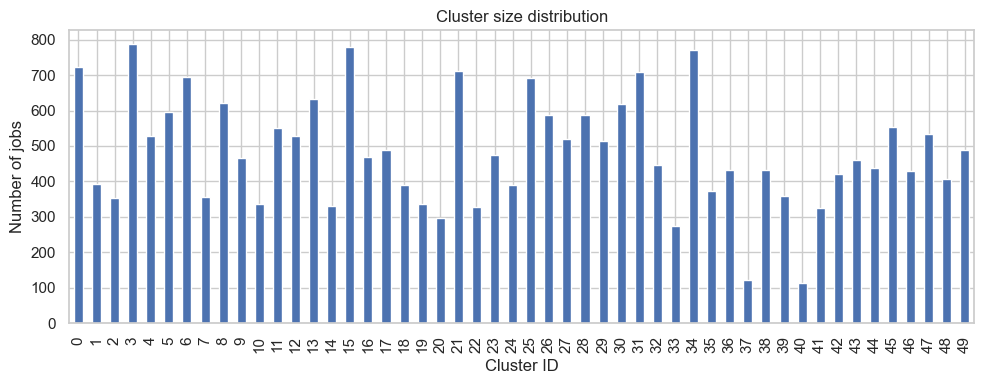

In [5]:
plt.figure(figsize=(10, 4))
cluster_sizes.plot(kind="bar")
plt.title("Cluster size distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of jobs")
plt.tight_layout()
plt.show()


Cell 5 – Internal cluster metrics

In [6]:
metrics = internal_cluster_metrics(embeddings, labels)
metrics


{'silhouette': 0.015975164249539375, 'davies_bouldin': 4.660137987116893}

Cell 6 – Attach labels back to jobs and inspect

In [7]:
jobs_with_labels = jobs.copy()
jobs_with_labels["cluster"] = labels

jobs_with_labels.head()


,company_id,name,description,company_size,state,country,city,zip_code,address,url,industry,speciality,employee_count,follower_count,time_recorded,cluster
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,IT Services and IT Consulting,Cloud,314102,16253625,1712378162,5
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,Hospitals and Health Care,Healthcare,56873,2185368,1712382540,44
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...,IT Services and IT Consulting,None,79528,3586194,1712870106,9
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle,IT Services and IT Consulting,enterprise,192099,9465968,1712642952,9
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture,Business Consulting and Services,Management Consulting,574664,11864908,1712641699,5


In [8]:
# Look at a few clusters and their most common job titles
jobs_with_labels.groupby("cluster")["speciality"].value_counts().groupby(level=0).head(3)


cluster  speciality           
0        Manufacturing            10
         HVAC                      8
         Aerospace                 6
1        Biotechnology            12
         Oncology                  4
                                  ..
48       Staffing                  5
         Engineering               4
49       Investment Management    16
         Financial Planning       12
         Wealth Management        12
Name: count, Length: 150, dtype: int64

Cell 7 – Inspect a single cluster in detail

In [9]:
cluster_id = 0  # change as you like
cluster_sample = jobs_with_labels[jobs_with_labels["cluster"] == cluster_id].head(10)
cluster_sample[[cfg["jobs"]["id_column"], "speciality", "name", TEXT_COL]]


,company_id,speciality,name,description
171,1906,Military systems,General Dynamics Land Systems,Innovation is in Our DNA \n\nGeneral Dynamics ...
195,2089,Marine and Industrial engines,Volvo Penta,Volvo Penta is a world-leading supplier of eng...
198,2096,Articulated Haulers,Volvo Construction Equipment,Volvo Construction Equipment (Volvo CE) is a g...
243,2425,Aircraft Engines,Pratt & Whitney,"Pratt & Whitney, an RTX business, is a global ..."
311,2722,Semiconductor Process Control,KLA,KLA develops industry-leading equipment and se...
344,2882,Energy,ITT Inc.,"At ITT, we have a clear purpose as an organiza..."
354,2931,Electronics Manufacturing,Teradyne,Teradyne brings high-quality innovations such ...
396,3119,Vacuum pumps,Edwards Vacuum,We are a global leader of vacuum and abatement...
444,7312936,Design,Nalbach Engineering,"For over 75 years, Nalbach Engineering has ear..."
529,3789,Agriculture,John Deere,"Founded in 1837, John Deere is a world leader ..."
